In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

queries = ('q11', 'q12', 'q13', 'q21', 'q22', 'q23', 'q31', 'q32', 'q33', 'q34', 'q41', 'q42', 'q43')

In [2]:
def plot_data(comparison_df, labels_mappings, title=None):
    # plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.style.use('seaborn-v0_8-muted')

    x = np.arange(len(comparison_df))
    width = 1 / (len(labels_mappings) + 1)
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

    #iterate on some columns and plot them in a single bar chart
    for col, label in labels_mappings.items():
        offset = width * multiplier
        std_col = f'{col[:-4]}_std'
        if std_col in comparison_df.columns:
            rects = ax.bar(x + offset, comparison_df[col], width=width, label=label, yerr=comparison_df[std_col], capsize=3)
        else:
            rects = ax.bar(x + offset, comparison_df[col], width=width, label=label)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.legend()
    # ax.set_ylim(0, 60)
    ax.set_xticks(x + width, comparison_df['query'])
    ax.set_ylabel('Execution time (ms)')
    ax.set_axisbelow(True)
    ax.grid(color='black', linestyle='--', linewidth=0.5, zorder=1000, axis='y')
    if title:
        ax.set_title(title)

    plt.show()

In [3]:
results = pd.DataFrame()
for q in queries:
    data_sync = pd.read_csv(f'{q}-performance-sync.log', header=None, names=['execution_time_ms'])
    data_async = pd.read_csv(f'{q}-performance.log', header=None, names=['execution_time_ms'])
    data_fusion = pd.read_csv(f'{q}-performance-fusion.log', header=None, names=['execution_time_ms'])

    data_ddor = pd.read_csv(f'{q}-performance-ddor.log', header=None, names=['execution_time_ms'])
    data_ddor_fusion = pd.read_csv(f'{q}-performance-ddor-fusion.log', header=None, names=['execution_time_ms'])
    data_ddor_1seg = pd.read_csv(f'{q}-performance-ddor-1seg.log', header=None, names=['execution_time_ms'])

    data_heavydb_transformed = pd.read_csv(f'heavydb_perf/transformed/{q}.txt', header=None, names=['execution_time_ms'])
    data_heavydb_original = pd.read_csv(f'heavydb_perf/original/{q}.txt', header=None, names=['execution_time_ms'])

    results[f'{q}_sync'] = data_sync['execution_time_ms']
    results[f'{q}_async'] = data_async['execution_time_ms']
    results[f'{q}_fusion'] = data_fusion['execution_time_ms']

    results[f'{q}_ddor'] = data_ddor['execution_time_ms']
    results[f'{q}_ddor_fusion'] = data_ddor_fusion['execution_time_ms']
    results[f'{q}_ddor_1seg'] = data_ddor_1seg['execution_time_ms']


    results[f'{q}_heavydb_transformed'] = data_heavydb_transformed['execution_time_ms']
    results[f'{q}_heavydb_original'] = data_heavydb_original['execution_time_ms']

results.describe()

/tmp/ipykernel_3723257/3333556199.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'{q}_ddor_fusion'] = data_ddor_fusion['execution_time_ms']
/tmp/ipykernel_3723257/3333556199.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'{q}_ddor_1seg'] = data_ddor_1seg['execution_time_ms']
/tmp/ipykernel_3723257/3333556199.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

,q11_sync,q11_async,q11_fusion,q11_ddor,q11_ddor_fusion,q11_ddor_1seg,q11_heavydb_transformed,q11_heavydb_original,q12_sync,q12_async,...,q42_heavydb_transformed,q42_heavydb_original,q43_sync,q43_async,q43_fusion,q43_ddor,q43_ddor_fusion,q43_ddor_1seg,q43_heavydb_transformed,q43_heavydb_original
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,13.066991,12.740236,13.988446,14.620223,9.450162,9.830411,18.020000,14.590000,14.023130,13.684812,...,52.390000,50.470000,14.213607,12.481374,15.053533,13.360693,93.172927,17.884246,54.940000,66.120000
std,0.058390,0.184307,12.849264,26.183252,16.584807,15.897694,5.508451,4.114755,0.072740,0.175961,...,16.095608,14.940593,1.048972,0.903446,9.871079,0.260600,94.455202,32.064517,85.361006,82.694189
min,13.007900,12.659700,8.117700,11.817800,4.350770,7.119990,11.000000,11.000000,13.943600,13.607900,...,44.000000,45.000000,12.864300,11.603900,9.931090,12.996500,8.285610,10.339100,41.000000,52.000000
25%,13.040025,12.678350,8.605775,11.969600,4.603455,7.247930,13.750000,12.000000,13.989675,13.630175,...,45.000000,45.000000,13.154550,11.771575,11.486375,13.158050,8.685177,10.493350,43.000000,53.000000
50%,13.056750,12.687000,8.764440,11.991800,6.298060,7.288360,17.500000,13.000000,14.008150,13.637250,...,53.000000,46.000000,14.339450,12.058800,12.384700,13.422050,9.075500,10.677150,46.000000,57.000000
75%,13.074275,12.704500,8.957413,12.028850,6.646415,7.335085,21.000000,17.000000,14.038375,13.646550,...,55.000000,53.000000,14.808900,13.134150,12.933650,13.475625,187.992750,10.915450,51.000000,62.000000
max,13.519900,14.070100,67.230100,273.833000,109.150000,144.532000,43.000000,44.000000,14.484600,15.004200,...,204.000000,191.000000,17.193600,15.427900,51.903100,15.117100,246.409000,205.800000,899.000000,883.000000


note on the above: fusion std also takes in consideration when the JIT if the fusion happens, which has way higher execution times. When making plots, we filter out those cases.

In [4]:
comparison = []

for q in queries:
    sync_avg = results[f'{q}_sync'].mean()
    async_avg = results[f'{q}_async'].mean()
    fusion_avg = results[results[f'{q}_fusion'] < 20.0][f'{q}_fusion'].mean()
    ddor_avg = results[results[f'{q}_ddor'] < 20.0][f'{q}_ddor'].mean()
    ddor_fusion_avg = results[results[f'{q}_ddor_fusion'] < 20.0][f'{q}_ddor_fusion'].mean()
    ddor_1seg_avg = results[results[f'{q}_ddor_1seg'] < 20.0][f'{q}_ddor_1seg'].mean()

    heavydb_transformed_avg = results[1:][f'{q}_heavydb_transformed'].mean()
    heavydb_original_avg = results[1:][f'{q}_heavydb_original'].mean()
    speedup_async = (sync_avg - async_avg) / sync_avg
    speedup_fusion = (sync_avg - fusion_avg) / sync_avg
    fusion_async = (async_avg - fusion_avg) / async_avg
    heavydb_original_async = (async_avg - heavydb_original_avg) / async_avg
    heavydb_transformed_async = (async_avg - heavydb_transformed_avg) / async_avg
    # print(f'{q}: Sync avg = {sync_avg:5.2f} ms, Async avg = {async_avg:5.2f} ms, Fusion avg = {fusion_avg:5.2f} ms, Speedup async on sync = {speedup_async:6.2%}, Speedup fusion on sync = {speedup_fusion:6.2%}')

    comparison.append({
        'query': q,
        'sync_avg': sync_avg,
        'async_avg': async_avg,
        'fusion_avg': fusion_avg,

        'ddor_avg': ddor_avg,
        'ddor_fusion_avg': ddor_fusion_avg,
        'ddor_1seg_avg': ddor_1seg_avg,

        'heavydb_transformed_avg': heavydb_transformed_avg,
        'heavydb_original_avg': heavydb_original_avg,
        
        'async_sync': speedup_async * 100,
        'fusion_sync': speedup_fusion * 100,
        'fusion_async': fusion_async * 100,
        'heavydb_original_async': heavydb_original_async * 100,
        'heavydb_transformed_async': heavydb_transformed_async * 100,
    })

comparison = pd.DataFrame(comparison)
# comparison.set_index('query', inplace=True)
comparison

,query,sync_avg,async_avg,fusion_avg,ddor_avg,ddor_fusion_avg,ddor_1seg_avg,heavydb_transformed_avg,heavydb_original_avg,async_sync,fusion_sync,fusion_async,heavydb_original_async,heavydb_transformed_async
0,q11,13.066991,12.740236,8.739595,12.001912,5.798595,7.301964,17.767677,14.292929,2.500614,33.117005,31.401624,-12.187320,-39.461127
1,q12,14.023130,13.684812,9.085047,12.879705,6.121062,8.516530,14.717172,14.666667,2.412571,35.213846,33.612193,-7.174776,-7.543836
2,q13,13.997501,13.627748,8.856918,12.565472,5.920466,8.526252,13.232323,14.525253,2.641564,36.725009,35.008208,-6.585861,2.901615
3,q21,12.816319,12.031894,11.843347,13.646247,11.499407,11.180511,31.010101,29.818182,6.120517,7.591668,1.567063,-147.826168,-157.732498
4,q22,10.199652,9.333765,8.835067,11.505088,8.180138,7.974831,29.919192,31.898990,8.489377,13.378743,5.342950,-241.759071,-220.547931
5,q23,8.615798,7.784594,6.193019,7.706031,5.120477,7.282293,29.545455,28.696970,9.647448,28.120191,20.445181,-268.637989,-279.537529
6,q31,15.705098,14.747863,13.718777,14.884217,12.701189,13.358249,31.313131,27.555556,6.095059,12.647621,6.977867,-86.844396,-112.323177
7,q32,10.701047,9.443966,9.004991,11.624402,8.161425,8.465336,53.353535,51.707071,11.747272,15.849438,4.648203,-447.514391,-464.948430
8,q33,9.606535,8.106762,7.584868,8.400735,6.017290,7.754491,51.151515,49.000000,15.612004,21.044701,6.437760,-504.433667,-530.973426
9,q34,9.371616,7.872036,7.741775,8.169958,5.884066,7.724434,52.707071,51.797980,16.001298,17.391256,1.654738,-557.999775,-569.548133


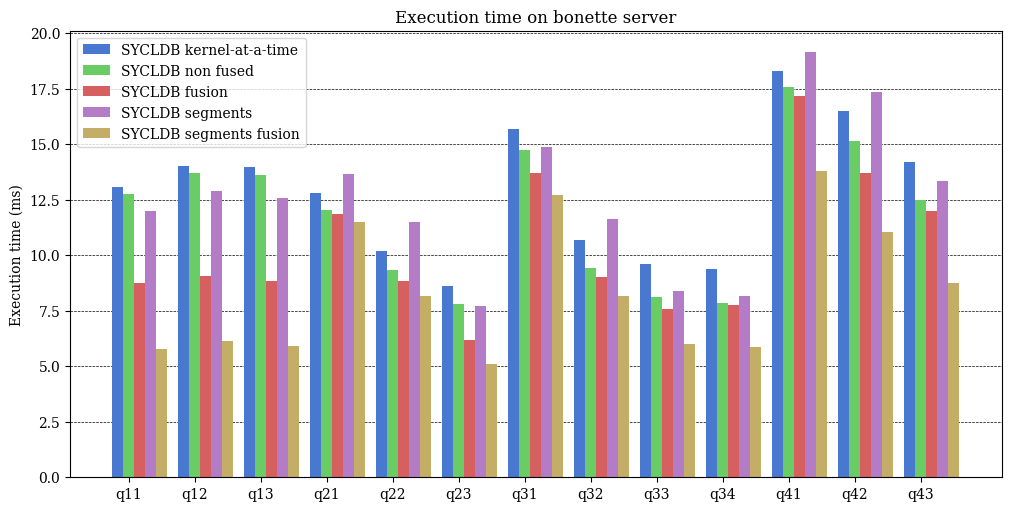

In [5]:
labels_mapping = {
    # 'heavydb_original_avg': 'HeavyDB',
    'sync_avg': 'SYCLDB kernel-at-a-time',
    'async_avg': 'SYCLDB non fused',
    'fusion_avg': 'SYCLDB fusion',
    'ddor_avg': 'SYCLDB segments',
    'ddor_fusion_avg': 'SYCLDB segments fusion',
}

plot_data(comparison, labels_mapping, title='Execution time on bonette server')

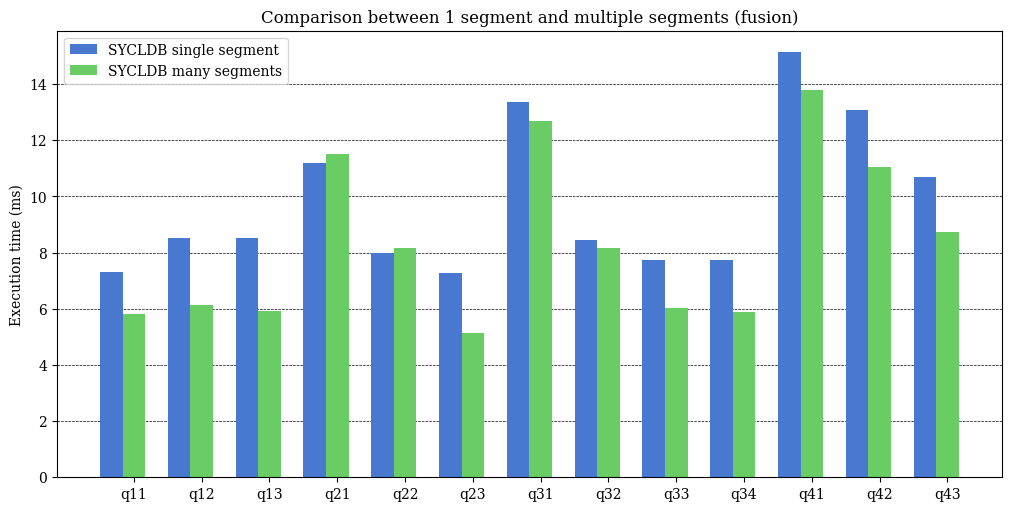

In [6]:
labels_mapping = {
    'ddor_1seg_avg': 'SYCLDB single segment',
    'ddor_fusion_avg': 'SYCLDB many segments',
}

plot_data(comparison, labels_mapping, title='Comparison between 1 segment and multiple segments (fusion)')

In [7]:
results_cxl = pd.DataFrame()

query_times_crystal = defaultdict(list)

with open('crystal/results.txt') as f:
    for line in f:
        query, time = line.split(': ')
        assert f'q{query}' in queries
        query_times_crystal[f'q{query}'].append(float(time))

for q in queries:
    sync_df = pd.read_csv(f'{q}-performance-sync-cxl.log', header=None, names=['execution_time_ms'])
    async_df = pd.read_csv(f'{q}-performance-async-cxl.log', header=None, names=['execution_time_ms'])
    fusion_df = pd.read_csv(f'{q}-performance-cxl.log', header=None, names=['execution_time_ms'])
    ddor_df = pd.read_csv(f'{q}-performance-ddor-l40.log', header=None, names=['execution_time_ms'])
    heavydb_df = pd.read_csv(f'heavydb_perf/cxl_server/{q}.txt', header=None, names=['execution_time_ms'])

    results_cxl[f'{q}_sync'] = sync_df['execution_time_ms']
    results_cxl[f'{q}_async'] = async_df['execution_time_ms']
    results_cxl[f'{q}_fusion'] = fusion_df['execution_time_ms']
    results_cxl[f'{q}_ddor'] = ddor_df['execution_time_ms']
    results_cxl[f'{q}_crystal'] = query_times_crystal[q]
    results_cxl[f'{q}_heavydb'] = heavydb_df['execution_time_ms']

results_cxl.describe()

,q11_sync,q11_async,q11_fusion,q11_ddor,q11_crystal,q11_heavydb,q12_sync,q12_async,q12_fusion,q12_ddor,...,q42_fusion,q42_ddor,q42_crystal,q42_heavydb,q43_sync,q43_async,q43_fusion,q43_ddor,q43_crystal,q43_heavydb
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.336749,6.950151,4.937993,10.540893,2.561560,59.24000,7.480610,7.138039,4.165261,10.043729,...,14.708136,8.338601,4.390494,42.810000,6.958989,5.160976,12.794509,5.823720,4.735919,38.430000
std,0.211763,0.018197,6.836804,4.452602,0.020717,9.57387,0.037796,0.015252,7.044130,4.122568,...,27.430997,2.353345,0.040548,30.369674,0.150585,0.104624,27.730896,1.559775,0.737159,2.871859
min,7.265460,6.908720,4.019400,7.344420,2.555970,21.00000,7.424670,7.103940,3.348460,7.623600,...,5.769380,7.495770,4.351780,28.000000,6.833180,4.964030,3.780820,4.854610,4.566940,28.000000
25%,7.299835,6.940392,4.076265,7.908425,2.558393,55.00000,7.465530,7.130800,3.381823,8.227095,...,5.897032,7.701367,4.372357,40.000000,6.899707,5.136178,3.870893,5.159538,4.623223,38.000000
50%,7.310225,6.947635,4.229905,7.971005,2.559360,57.50000,7.478720,7.137390,3.393810,8.285220,...,6.035170,7.790340,4.378145,40.000000,6.934425,5.174730,3.994200,5.206475,4.636400,39.000000
75%,7.321115,6.957540,4.397405,14.021850,2.560245,63.00000,7.487570,7.142658,3.477768,8.469508,...,6.153363,7.982430,4.390867,40.000000,6.964735,5.197740,4.039580,5.261180,4.656040,39.000000
max,9.391660,7.075760,72.599500,19.389400,2.765820,93.00000,7.805730,7.239370,73.885200,22.573600,...,122.221000,30.190400,4.672350,342.000000,8.202850,5.964000,121.456000,12.362800,11.831500,52.000000


note on the above: fusion std also takes in consideration when the JIT if the fusion happens, which has way higher execution times. When making plots, we filter out those cases.

In [8]:
comparison_cxl = []

for q in queries:
    sync_avg = results_cxl[f'{q}_sync'].mean()
    async_avg = results_cxl[f'{q}_async'].mean()
    fusion_avg = results_cxl[results_cxl[f'{q}_fusion'] < 12.0][f'{q}_fusion'].mean()
    ddor_avg = results_cxl[results_cxl[f'{q}_ddor'] < 12.0][f'{q}_ddor'].mean()
    crystal_avg = results_cxl[f'{q}_crystal'].mean()
    heavydb_avg = results_cxl[f'{q}_heavydb'].mean()

    speedup_async = (sync_avg - async_avg) / sync_avg
    speedup_fusion = (sync_avg - fusion_avg) / sync_avg
    fusion_async = (async_avg - fusion_avg) / async_avg

    comparison_cxl.append({
        'query': q,
        'sync_avg': sync_avg,
        'async_avg': async_avg,
        'fusion_avg': fusion_avg,
        'ddor_avg': ddor_avg,
        'crystal_avg': crystal_avg,
        'heavydb_avg': heavydb_avg,
        'async_sync': speedup_async * 100,
        'fusion_sync': speedup_fusion * 100,
        'fusion_async': fusion_async * 100,
    })

comparison_cxl = pd.DataFrame(comparison_cxl)
comparison_cxl

,query,sync_avg,async_avg,fusion_avg,ddor_avg,crystal_avg,heavydb_avg,async_sync,fusion_sync,fusion_async
0,q11,7.336749,6.950151,4.254544,7.953494,2.561560,59.24,5.269335,42.010505,38.784875
1,q12,7.480610,7.138039,3.461019,8.228944,2.562193,50.85,4.579461,53.733466,51.513024
2,q13,7.483421,7.108058,3.465122,8.099892,2.566792,45.58,5.015932,53.696019,51.250792
3,q21,5.611103,3.984008,3.681126,6.032179,2.830008,37.64,28.997785,34.395677,7.602428
4,q22,4.242118,3.817336,2.891345,4.901199,2.824962,35.34,10.013446,31.841941,24.257507
5,q23,3.986156,3.468662,2.829190,4.574296,2.910000,33.87,12.982283,29.024609,18.435701
6,q31,6.089624,5.596906,5.563098,7.517752,3.424333,36.66,8.091096,8.646274,0.604052
7,q32,4.540167,3.533796,2.899741,4.845912,3.301502,70.91,22.165960,36.131404,17.942592
8,q33,4.553606,3.531522,2.914190,4.507790,3.142639,71.48,22.445587,36.002578,17.480619
9,q34,4.286777,3.005747,2.617846,3.841732,3.144365,74.49,29.883278,38.932076,12.905335


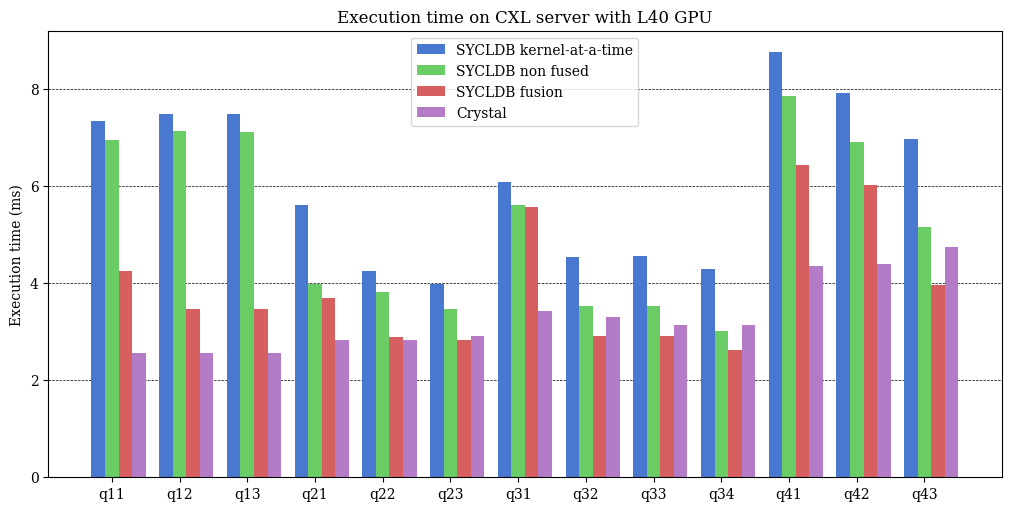

In [9]:
labels_mapping = {
    'sync_avg': 'SYCLDB kernel-at-a-time',
    'async_avg': 'SYCLDB non fused',
    'fusion_avg': 'SYCLDB fusion',
    # 'ddor_avg': 'SYCLDB segments',
    'crystal_avg': 'Crystal',
    # 'heavydb_avg': 'HeavyDB',
}

plot_data(comparison_cxl, labels_mapping, title='Execution time on CXL server with L40 GPU')

In [10]:
numa_results = pd.DataFrame()

for q in queries:
    numa0_df = pd.read_csv(f'{q}-performance-cxl-numa-0.log', header=None, names=['execution_time_ms'])
    numa1_df = pd.read_csv(f'{q}-performance-cxl-numa-1.log', header=None, names=['execution_time_ms'])
    numa2_df = pd.read_csv(f'{q}-performance-cxl-numa-2.log', header=None, names=['execution_time_ms'])

    numa_results[f'{q}_gpu_memory'] = results_cxl[f'{q}_async']
    numa_results[f'{q}_numa_0'] = numa0_df['execution_time_ms']
    numa_results[f'{q}_numa_1'] = numa1_df['execution_time_ms']
    numa_results[f'{q}_numa_2'] = numa2_df['execution_time_ms']

numa_results.describe()

,q11_gpu_memory,q11_numa_0,q11_numa_1,q11_numa_2,q12_gpu_memory,q12_numa_0,q12_numa_1,q12_numa_2,q13_gpu_memory,q13_numa_0,...,q41_numa_1,q41_numa_2,q42_gpu_memory,q42_numa_0,q42_numa_1,q42_numa_2,q43_gpu_memory,q43_numa_0,q43_numa_1,q43_numa_2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,6.950151,318.306590,273.049860,464.140530,7.138039,376.272150,225.244270,444.699620,7.108058,366.738500,...,728.011910,993.724270,6.899841,495.992920,361.613720,632.556150,5.160976,341.358260,299.736290,483.115480
std,0.018197,76.424709,59.610625,14.335661,0.015252,6.382141,7.173372,17.402467,0.017948,32.413827,...,38.292409,12.426582,0.087539,14.684661,24.059826,11.814545,0.104624,13.889173,1.740888,7.069451
min,6.908720,234.079000,232.263000,424.068000,7.103940,366.700000,220.188000,417.533000,7.079930,228.945000,...,711.442000,966.630000,6.787440,363.139000,351.991000,612.644000,4.964030,298.606000,299.031000,469.112000
25%,6.940392,236.069000,234.040000,453.522250,7.130800,370.080500,222.303000,423.001000,7.100548,368.962750,...,715.223250,984.575250,6.853080,492.614250,354.007000,621.372750,5.136178,338.511250,299.171250,477.018250
50%,6.947635,383.992000,236.248500,464.913500,7.137390,373.765500,223.016500,446.310500,7.105935,370.656000,...,716.219500,996.505500,6.889060,494.260000,355.123500,632.004500,5.174730,339.884000,299.345500,483.484000
75%,6.957540,386.875500,352.466500,478.057500,7.142658,382.369750,224.465750,457.029000,7.112785,380.520750,...,718.163500,1001.517500,6.932507,503.577750,358.094500,640.724250,5.197740,353.330500,299.650750,486.433500
max,7.075760,407.071000,395.053000,489.245000,7.239370,390.848000,264.362000,474.223000,7.234380,396.591000,...,893.348000,1013.850000,7.576070,510.012000,489.815000,655.973000,5.964000,358.399000,311.198000,502.132000


In [11]:
comparison_numa = []

for q in queries:
    gpu_memory_avg = numa_results[f'{q}_gpu_memory'].mean()
    numa_0_avg = numa_results[f'{q}_numa_0'].mean()
    numa_1_avg = numa_results[f'{q}_numa_1'].mean()
    numa_2_avg = numa_results[f'{q}_numa_2'].mean()

    comparison_numa.append({
        'query': q,
        'gpu_memory_avg': gpu_memory_avg,
        'numa_0_avg': numa_0_avg,
        'numa_1_avg': numa_1_avg,
        'numa_2_avg': numa_2_avg,
    })

comparison_numa = pd.DataFrame(comparison_numa)
comparison_numa

,query,gpu_memory_avg,numa_0_avg,numa_1_avg,numa_2_avg
0,q11,6.950151,318.30659,273.04986,464.14053
1,q12,7.138039,376.27215,225.24427,444.69962
2,q13,7.108058,366.73850,233.63129,454.54244
3,q21,3.984008,395.52294,415.53723,567.41775
4,q22,3.817336,368.47590,381.30539,515.46220
5,q23,3.468662,272.22182,278.05195,387.48363
6,q31,5.596906,376.45534,416.88774,518.73857
7,q32,3.533796,122.17737,119.25486,169.81803
8,q33,3.531522,104.55027,104.66985,141.01519
9,q34,3.005747,107.54815,104.27973,141.15548


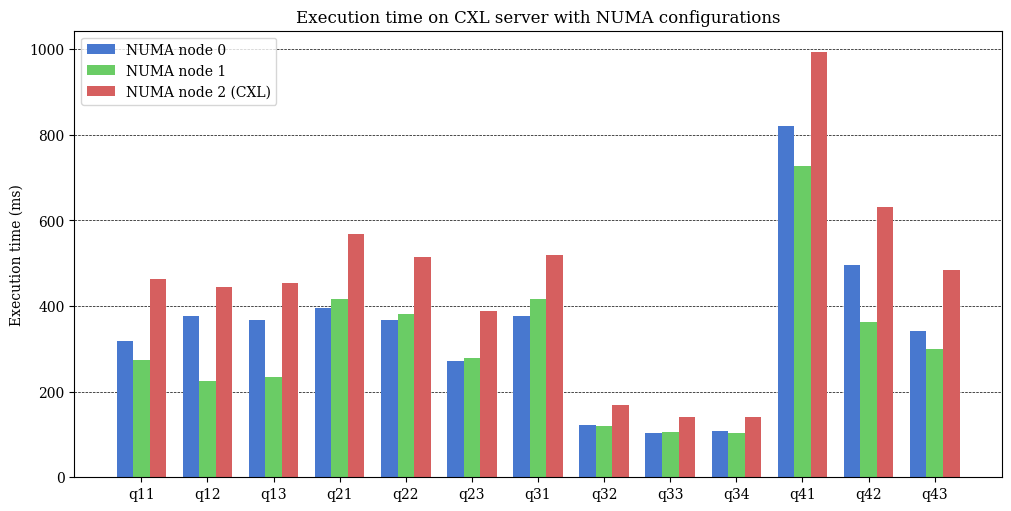

In [12]:
labels_mapping = {
    # 'gpu_memory_avg': 'SYCLDB GPU',
    'numa_0_avg': 'NUMA node 0',
    'numa_1_avg': 'NUMA node 1',
    'numa_2_avg': 'NUMA node 2 (CXL)',
}

plot_data(comparison_numa, labels_mapping, title='Execution time on CXL server with NUMA configurations')

In [13]:
cpu_results = pd.DataFrame()
duckdb_results_s20 = pd.read_csv('results_duckdb_s20.csv')
duckdb_results_s100 = pd.read_csv('results_duckdb_s100.csv')
duckdb_results_s160 = pd.read_csv('results_duckdb_s160.csv')
duckdb_results_s250 = pd.read_csv('results_duckdb_s250.csv')
duckdb_results_s500 = pd.read_csv('results_duckdb_s500.csv')
duckdb_results_s1000 = pd.read_csv('results_duckdb_s1000.csv')

duckdb_results_s20_bonette = pd.read_csv('results_duckdb_s20_bonette.csv')
duckdb_results_s40_bonette = pd.read_csv('results_duckdb_s40_bonette.csv')
duckdb_results_s100_bonette = pd.read_csv('results_duckdb_s100_bonette.csv')
duckdb_results_s160_bonette = pd.read_csv('results_duckdb_s160_bonette.csv')

for q in queries:
    cpu_s20_df = pd.read_csv(f'{q}-performance-cxl-cpu-s20.log', header=None, names=['execution_time_ms'])
    cpu_s100_df = pd.read_csv(f'{q}-performance-cxl-cpu-s100.log', header=None, names=['execution_time_ms'])
    cpu_s160_df = pd.read_csv(f'{q}-performance-cxl-cpu-s160.log', header=None, names=['execution_time_ms'])
    cpu_s160_2_df = pd.read_csv(f'{q}-performance-cxl-cpu-s160.log-2', header=None, names=['execution_time_ms'])
    cpu_s250_df = pd.read_csv(f'{q}-performance-cxl-cpu-s250.log', header=None, names=['execution_time_ms'])

    mordred_s160_df = pd.read_csv(f'{q}-mordred-s160.log', header=None, names=['execution_time_ms'])
    mordred_s160_2_df = pd.read_csv(f'{q}-mordred-s160.log-2', header=None, names=['execution_time_ms'])

    mordred_s40_bonette_df = pd.read_csv(f'{q}-mordred-s40-bonette.log', header=None, names=['execution_time_ms'])
    mordred_s160_bonette_df = pd.read_csv(f'{q}-mordred-s160-bonette.log', header=None, names=['execution_time_ms'])

    cpu_s20_bonette_df = pd.read_csv(f'{q}-performance-cpu-s20.log', header=None, names=['execution_time_ms'])
    cpu_s40_bonette_df = pd.read_csv(f'{q}-performance-cpu-s40.log', header=None, names=['execution_time_ms'])
    cpu_s100_bonette_df = pd.read_csv(f'{q}-performance-cpu-s100.log', header=None, names=['execution_time_ms'])
    cpu_s160_bonette_df = pd.read_csv(f'{q}-performance-cpu-s160.log', header=None, names=['execution_time_ms'])

    cpu_results[f'{q}_cpu_s20'] = cpu_s20_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s100'] = cpu_s100_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s160'] = cpu_s160_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s160_2'] = cpu_s160_2_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s250'] = cpu_s250_df['execution_time_ms']

    cpu_results[f'{q}_mordred_s160'] = mordred_s160_df['execution_time_ms']
    cpu_results[f'{q}_mordred_s160_2'] = mordred_s160_2_df['execution_time_ms']

    cpu_results[f'{q}_mordred_s40_bonette'] = mordred_s40_bonette_df['execution_time_ms']
    cpu_results[f'{q}_mordred_s160_bonette'] = mordred_s160_bonette_df['execution_time_ms']

    cpu_results[f'{q}_cpu_s20_bonette'] = cpu_s20_bonette_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s40_bonette'] = cpu_s40_bonette_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s100_bonette'] = cpu_s100_bonette_df['execution_time_ms']
    cpu_results[f'{q}_cpu_s160_bonette'] = cpu_s160_bonette_df['execution_time_ms']

    cpu_results[f'{q}_duckdb_s20'] = duckdb_results_s20[q]
    cpu_results[f'{q}_duckdb_s100'] = duckdb_results_s100[q]
    cpu_results[f'{q}_duckdb_s160'] = duckdb_results_s160[q]
    cpu_results[f'{q}_duckdb_s250'] = duckdb_results_s250[q]
    cpu_results[f'{q}_duckdb_s500'] = duckdb_results_s500[q]
    cpu_results[f'{q}_duckdb_s1000'] = duckdb_results_s1000[q]

    cpu_results[f'{q}_duckdb_s20_bonette'] = duckdb_results_s20_bonette[q]
    cpu_results[f'{q}_duckdb_s40_bonette'] = duckdb_results_s40_bonette[q]
    cpu_results[f'{q}_duckdb_s100_bonette'] = duckdb_results_s100_bonette[q]
    cpu_results[f'{q}_duckdb_s160_bonette'] = duckdb_results_s160_bonette[q]

cpu_results[1:].describe()

/tmp/ipykernel_3723257/2079540205.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cpu_results[f'{q}_mordred_s160_bonette'] = mordred_s160_bonette_df['execution_time_ms']
/tmp/ipykernel_3723257/2079540205.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cpu_results[f'{q}_cpu_s20_bonette'] = cpu_s20_bonette_df['execution_time_ms']
/tmp/ipykernel_3723257/2079540205.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

,q11_cpu_s20,q11_cpu_s100,q11_cpu_s160,q11_cpu_s160_2,q11_cpu_s250,q11_mordred_s160,q11_mordred_s160_2,q11_mordred_s40_bonette,q11_mordred_s160_bonette,q11_cpu_s20_bonette,...,q43_duckdb_s20,q43_duckdb_s100,q43_duckdb_s160,q43_duckdb_s250,q43_duckdb_s500,q43_duckdb_s1000,q43_duckdb_s20_bonette,q43_duckdb_s40_bonette,q43_duckdb_s100_bonette,q43_duckdb_s160_bonette
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,323.306788,974.257000,1278.667980,1219.149495,2264.491313,85.240603,75.442199,80.079422,370.701111,126.894737,...,63.935827,305.281273,428.352669,583.029985,994.348107,2286.750984,126.659745,273.505924,594.355680,974.067563
std,9.301152,14.633729,106.279273,80.379342,67.337359,7.850522,0.449824,0.572978,17.752780,1.917171,...,5.391738,26.634055,101.597183,177.794691,401.515438,910.827358,1.759141,3.021107,8.491578,13.444414
min,313.095000,953.558000,1225.130000,1140.380000,2186.010000,82.292600,73.226700,79.261300,312.864000,125.306000,...,55.987597,264.388800,309.827089,403.534174,550.779581,987.729311,123.287916,267.377377,577.255487,947.754145
25%,317.601500,964.912500,1237.755000,1176.840000,2225.855000,83.611450,75.164750,79.763900,375.189500,125.788000,...,61.479092,287.858367,376.597881,484.984636,754.636168,1603.173375,125.421643,271.333575,588.427186,963.291764
50%,320.447000,971.298000,1246.200000,1200.370000,2248.890000,84.057200,75.458100,79.960600,376.260000,126.245000,...,62.853336,304.307699,410.015583,522.533894,830.235958,1941.719294,126.641989,273.122787,592.079878,971.977949
75%,325.335500,978.706000,1264.135000,1224.765000,2268.820000,84.778500,75.757450,80.163350,376.956500,127.309500,...,64.428329,319.765687,443.932533,590.595841,1082.841396,3000.156522,127.788186,275.316358,600.695014,981.929898
max,368.160000,1029.420000,1732.650000,1539.430000,2587.170000,140.801000,76.529900,82.581100,378.929000,138.078000,...,98.775864,445.880651,917.894125,1279.889107,2379.565716,4545.185089,131.302834,283.200264,622.029305,1012.542009


In [14]:
comparison_cpu = []

for q in queries:
    cpu_s20_avg = cpu_results[f'{q}_cpu_s20'][1:].mean()
    cpu_s100_avg = cpu_results[f'{q}_cpu_s100'][1:].mean()
    cpu_s160_avg = cpu_results[f'{q}_cpu_s160'][1:].mean()
    cpu_s160_std = cpu_results[f'{q}_cpu_s160'][1:].std()
    cpu_s160_2_avg = cpu_results[f'{q}_cpu_s160_2'][1:].mean()
    cpu_s160_2_std = cpu_results[f'{q}_cpu_s160_2'][1:].std()
    cpu_s250_avg = cpu_results[f'{q}_cpu_s250'][1:].mean()

    mordred_s160_avg = cpu_results[f'{q}_mordred_s160'][1:].mean()
    mordred_s160_std = cpu_results[f'{q}_mordred_s160'][1:].std()
    mordred_s160_2_avg = cpu_results[f'{q}_mordred_s160_2'][1:].mean()
    mordred_s160_2_std = cpu_results[f'{q}_mordred_s160_2'][1:].std()

    mordred_s40_bonette_avg = cpu_results[f'{q}_mordred_s40_bonette'][1:].mean()
    mordred_s40_bonette_std = cpu_results[f'{q}_mordred_s40_bonette'][1:].std()
    mordred_s160_bonette_avg = cpu_results[f'{q}_mordred_s160_bonette'][1:].mean()
    mordred_s160_bonette_std = cpu_results[f'{q}_mordred_s160_bonette'][1:].std()

    cpu_s20_bonette_avg = cpu_results[f'{q}_cpu_s20_bonette'][1:].mean()
    cpu_s40_bonette_avg = cpu_results[f'{q}_cpu_s40_bonette'][1:].mean()
    cpu_s40_bonette_std = cpu_results[f'{q}_cpu_s40_bonette'][1:].std()
    cpu_s100_bonette_avg = cpu_results[f'{q}_cpu_s100_bonette'][1:].mean()
    cpu_s160_bonette_avg = cpu_results[f'{q}_cpu_s160_bonette'][1:].mean()
    cpu_s160_bonette_std = cpu_results[f'{q}_cpu_s160_bonette'][1:].std()

    duckdb_avg = cpu_results[f'{q}_duckdb_s20'][1:].mean()
    duckdb_s100_avg = cpu_results[f'{q}_duckdb_s100'][1:].mean()
    duckdb_s160_avg = cpu_results[f'{q}_duckdb_s160'][1:].mean()
    duckdb_s160_std = cpu_results[f'{q}_duckdb_s160'][1:].std()
    duckdb_s250_avg = cpu_results[f'{q}_duckdb_s250'][1:].mean()
    duckdb_s500_avg = cpu_results[f'{q}_duckdb_s500'][1:].mean()
    duckdb_s1000_avg = cpu_results[f'{q}_duckdb_s1000'][1:].mean()

    duckdb_s20_bonette_avg = cpu_results[f'{q}_duckdb_s20_bonette'][1:].mean()
    duckdb_s40_bonette_avg = cpu_results[f'{q}_duckdb_s40_bonette'][1:].mean()
    duckdb_s40_bonette_std = cpu_results[f'{q}_duckdb_s40_bonette'][1:].std()
    duckdb_s100_bonette_avg = cpu_results[f'{q}_duckdb_s100_bonette'][1:].mean()
    duckdb_s160_bonette_avg = cpu_results[f'{q}_duckdb_s160_bonette'][1:].mean()
    duckdb_s160_bonette_std = cpu_results[f'{q}_duckdb_s160_bonette'][1:].std()

    comparison_cpu.append({
        'query': q,

        'cpu_s20_avg': cpu_s20_avg,
        'cpu_s100_avg': cpu_s100_avg,
        'cpu_s160_avg': cpu_s160_avg,
        'cpu_s160_std': cpu_s160_std,
        'cpu_s160_2_avg': cpu_s160_2_avg,
        'cpu_s160_2_std': cpu_s160_2_std,
        'cpu_s250_avg': cpu_s250_avg,

        'mordred_s160_avg': mordred_s160_avg,
        'mordred_s160_std': mordred_s160_std,
        'mordred_s160_2_avg': mordred_s160_2_avg,
        'mordred_s160_2_std': mordred_s160_2_std,

        'mordred_s40_bonette_avg': mordred_s40_bonette_avg,
        'mordred_s40_bonette_std': mordred_s40_bonette_std,
        'mordred_s160_bonette_avg': mordred_s160_bonette_avg,
        'mordred_s160_bonette_std': mordred_s160_bonette_std,

        'cpu_s20_bonette_avg': cpu_s20_bonette_avg,
        'cpu_s40_bonette_avg': cpu_s40_bonette_avg,
        'cpu_s40_bonette_std': cpu_s40_bonette_std,
        'cpu_s100_bonette_avg': cpu_s100_bonette_avg,
        'cpu_s160_bonette_avg': cpu_s160_bonette_avg,
        'cpu_s160_bonette_std': cpu_s160_bonette_std,

        'duckdb_s20_avg': duckdb_avg,
        'duckdb_s100_avg': duckdb_s100_avg,
        'duckdb_s160_avg': duckdb_s160_avg,
        'duckdb_s160_std': duckdb_s160_std,
        'duckdb_s250_avg': duckdb_s250_avg,
        'duckdb_s500_avg': duckdb_s500_avg,
        'duckdb_s1000_avg': duckdb_s1000_avg,

        'duckdb_s20_bonette_avg': duckdb_s20_bonette_avg,
        'duckdb_s40_bonette_avg': duckdb_s40_bonette_avg,
        'duckdb_s40_bonette_std': duckdb_s40_bonette_std,
        'duckdb_s100_bonette_avg': duckdb_s100_bonette_avg,
        'duckdb_s160_bonette_avg': duckdb_s160_bonette_avg,
        'duckdb_s160_bonette_std': duckdb_s160_bonette_std,
    })

comparison_cpu = pd.DataFrame(comparison_cpu)
comparison_cpu

,query,cpu_s20_avg,cpu_s100_avg,cpu_s160_avg,cpu_s160_std,cpu_s160_2_avg,cpu_s160_2_std,cpu_s250_avg,mordred_s160_avg,mordred_s160_std,...,duckdb_s160_std,duckdb_s250_avg,duckdb_s500_avg,duckdb_s1000_avg,duckdb_s20_bonette_avg,duckdb_s40_bonette_avg,duckdb_s40_bonette_std,duckdb_s100_bonette_avg,duckdb_s160_bonette_avg,duckdb_s160_bonette_std
0,q11,323.306788,974.257000,1278.667980,106.279273,1219.149495,80.379342,2264.491313,85.240603,7.850522,...,16.845278,109.202958,249.438483,499.239905,47.865319,90.759863,3.136273,227.433342,367.642764,14.033123
1,q12,51.435556,201.469576,262.778495,15.252033,592.611869,32.585272,476.235646,83.464809,11.673247,...,18.216566,103.968213,264.331729,507.903694,34.164518,64.391731,1.162545,162.119555,256.602576,5.999897
2,q13,48.466882,187.143030,270.592707,12.454712,592.451424,32.302548,458.701970,83.264672,12.116129,...,22.241350,161.958194,235.718257,432.020264,28.152049,47.123018,1.015748,117.870300,186.099031,5.951746
3,q21,50.309193,162.408192,223.077222,10.558689,481.960263,9.000329,413.285141,95.572295,19.544472,...,159.412965,509.401827,1181.013741,2079.745242,180.550190,467.639947,3.799632,1212.524038,1997.565479,12.734408
4,q22,48.705035,145.392535,228.889586,7.676116,463.905525,9.237776,397.805485,77.812360,19.314985,...,41.426332,456.921956,882.119718,1667.672810,176.804885,395.420426,2.401289,943.230285,1542.179782,10.704216
5,q23,43.037257,117.702091,151.574939,6.966709,353.389859,5.437225,340.746838,71.059921,15.081062,...,54.322945,366.219896,683.883905,1403.585116,162.386564,333.381537,1.733919,835.785601,1351.984241,10.414824
6,q31,70.438939,249.328687,320.211455,9.919325,647.530091,6.252826,593.897434,166.971586,9.925261,...,135.924943,1890.073468,1879.118700,3279.179713,217.645113,550.564906,3.113583,1288.145085,2271.109754,10.461228
7,q32,55.364261,184.005303,251.959273,9.917379,564.164717,7.597815,457.715303,92.703508,4.218762,...,58.736394,891.925949,1038.278874,2316.879961,168.040442,380.548677,3.518860,859.202570,1520.083548,13.132436
8,q33,54.243208,196.693747,225.442677,9.374800,552.751000,8.079487,476.087778,63.985792,6.418259,...,64.164790,495.154742,917.878943,1999.602780,156.960054,391.076464,2.645983,834.976680,1360.630888,9.216664
9,q34,52.848556,193.816727,223.339343,8.119054,553.546313,9.084996,533.409465,65.416320,13.904466,...,44.151808,286.957965,521.154635,1408.983139,60.710209,114.066300,2.422654,275.739272,416.585867,9.278681


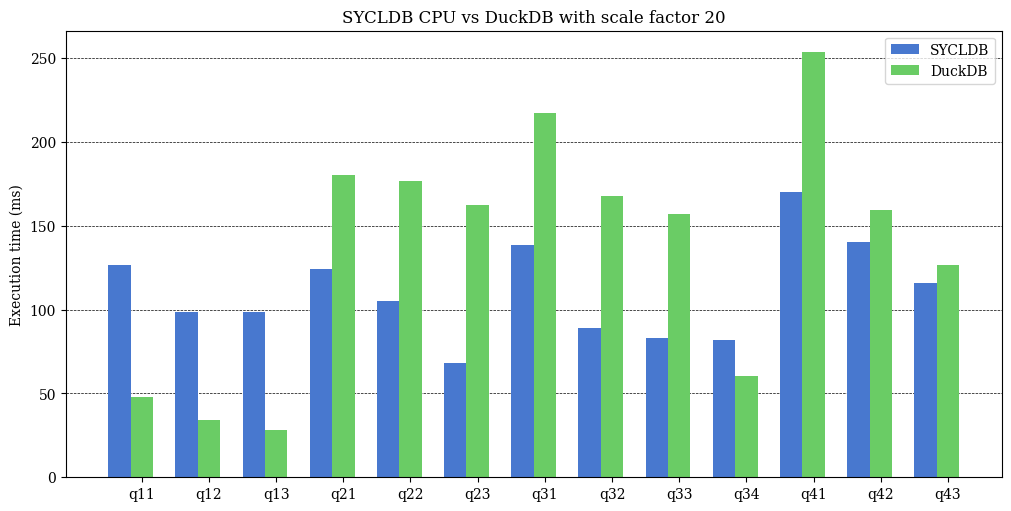

In [15]:
labels_mapping = {
    'cpu_s20_bonette_avg': 'SYCLDB',
    'duckdb_s20_bonette_avg': 'DuckDB',
}

plot_data(comparison_cpu, labels_mapping, title='SYCLDB CPU vs DuckDB with scale factor 20')

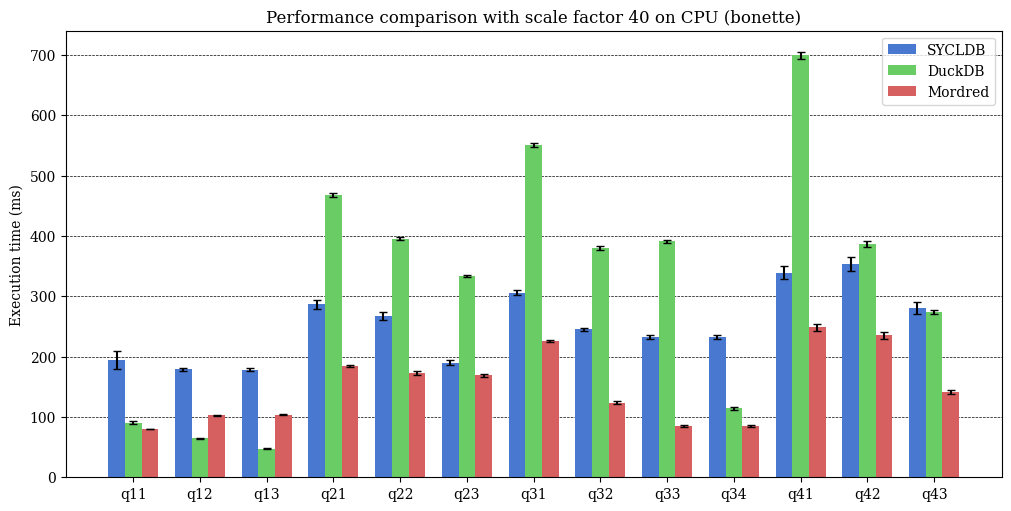

In [16]:
labels_mapping = {
    'cpu_s40_bonette_avg': 'SYCLDB',
    'duckdb_s40_bonette_avg': 'DuckDB',
    'mordred_s40_bonette_avg': 'Mordred',
}

plot_data(comparison_cpu, labels_mapping, title='Performance comparison with scale factor 40 on CPU (bonette)')

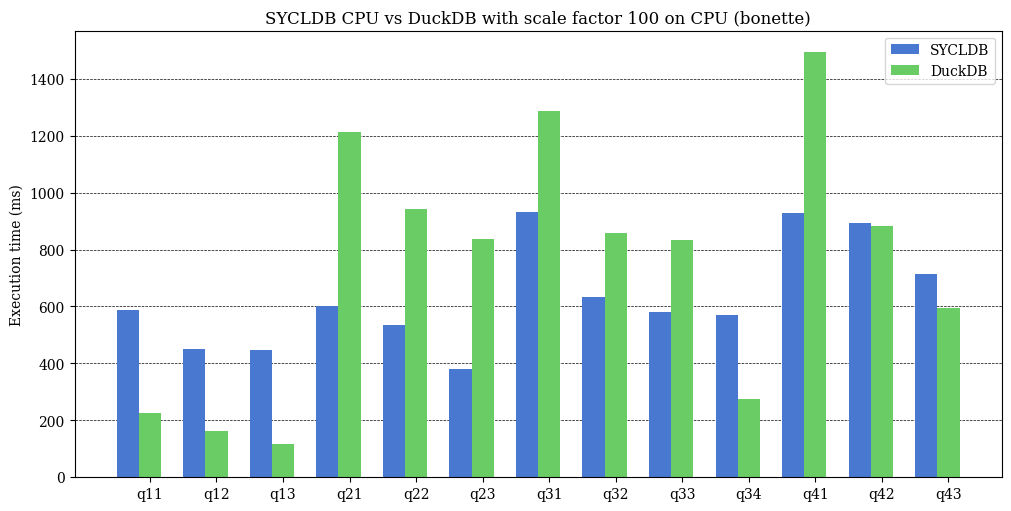

In [17]:
labels_mapping = {
    'cpu_s100_bonette_avg': 'SYCLDB',
    'duckdb_s100_bonette_avg': 'DuckDB',
}

plot_data(comparison_cpu, labels_mapping, title='SYCLDB CPU vs DuckDB with scale factor 100 on CPU (bonette)')

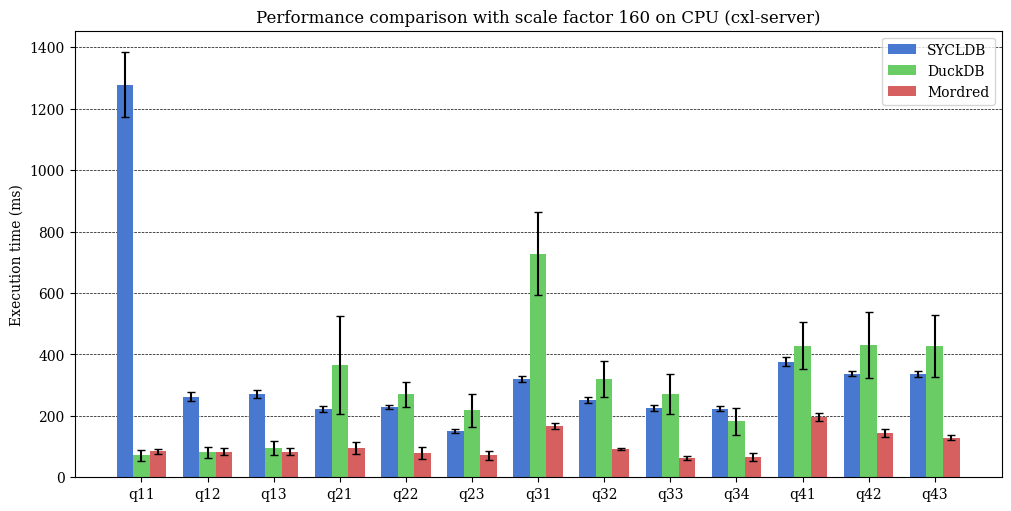

In [18]:
labels_mapping = {
    'cpu_s160_avg': 'SYCLDB',
    'duckdb_s160_avg': 'DuckDB',
    'mordred_s160_avg': 'Mordred',
}

plot_data(comparison_cpu, labels_mapping, title='Performance comparison with scale factor 160 on CPU (cxl-server)')

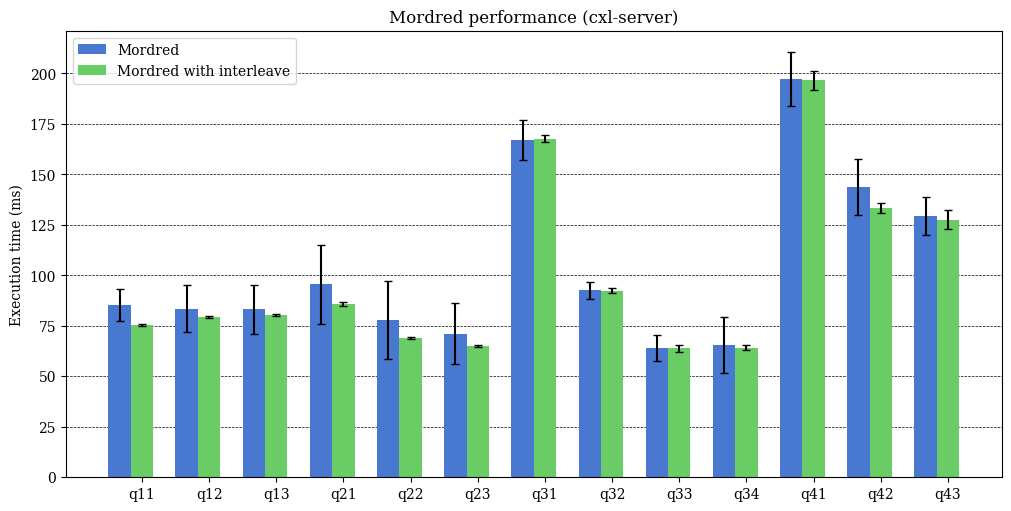

In [19]:
labels_mapping = {
    'mordred_s160_avg': 'Mordred',
    'mordred_s160_2_avg': 'Mordred with interleave',
}

plot_data(comparison_cpu, labels_mapping, title='Mordred performance (cxl-server)')

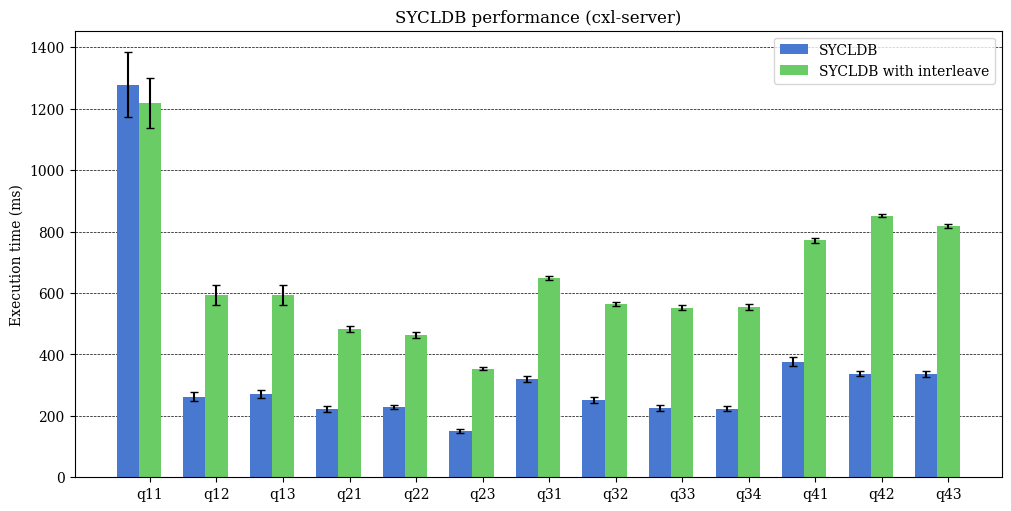

In [20]:
labels_mapping = {
    'cpu_s160_avg': 'SYCLDB',
    'cpu_s160_2_avg': 'SYCLDB with interleave',
}

plot_data(comparison_cpu, labels_mapping, title='SYCLDB performance (cxl-server)')

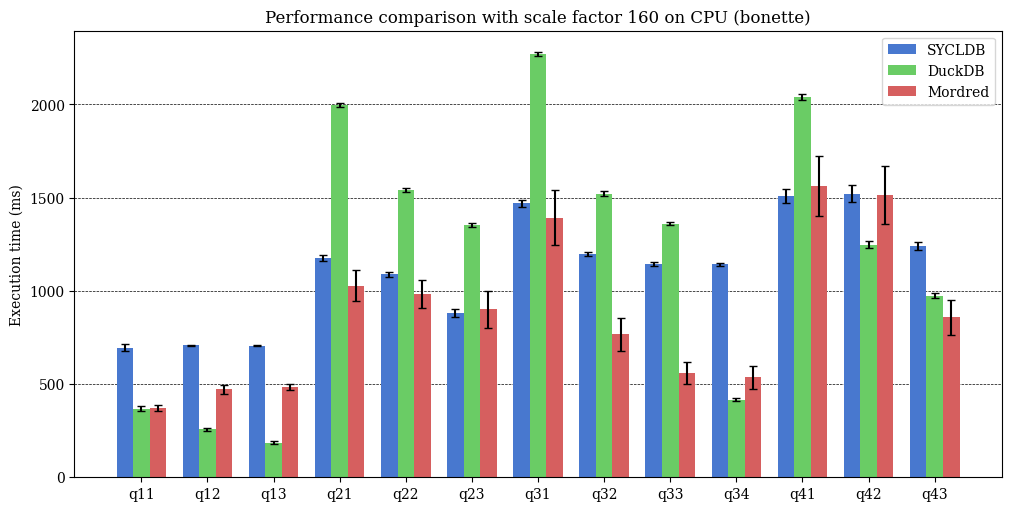

In [21]:
labels_mapping = {
    'cpu_s160_bonette_avg': 'SYCLDB',
    'duckdb_s160_bonette_avg': 'DuckDB',
    'mordred_s160_bonette_avg': 'Mordred',
}

plot_data(comparison_cpu, labels_mapping, title='Performance comparison with scale factor 160 on CPU (bonette)')

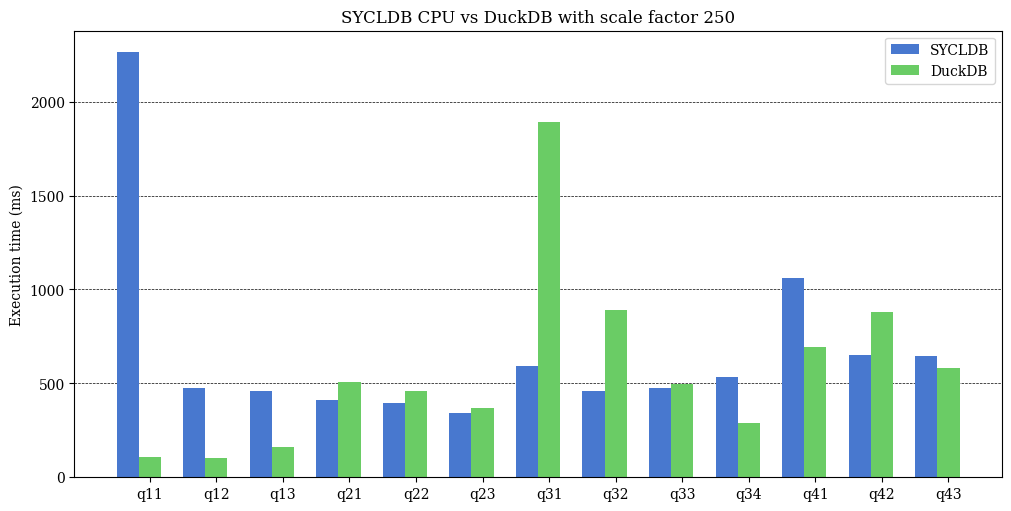

In [22]:
labels_mapping = {
    'cpu_s250_avg': 'SYCLDB',
    'duckdb_s250_avg': 'DuckDB',
}

plot_data(comparison_cpu, labels_mapping, title='SYCLDB CPU vs DuckDB with scale factor 250')

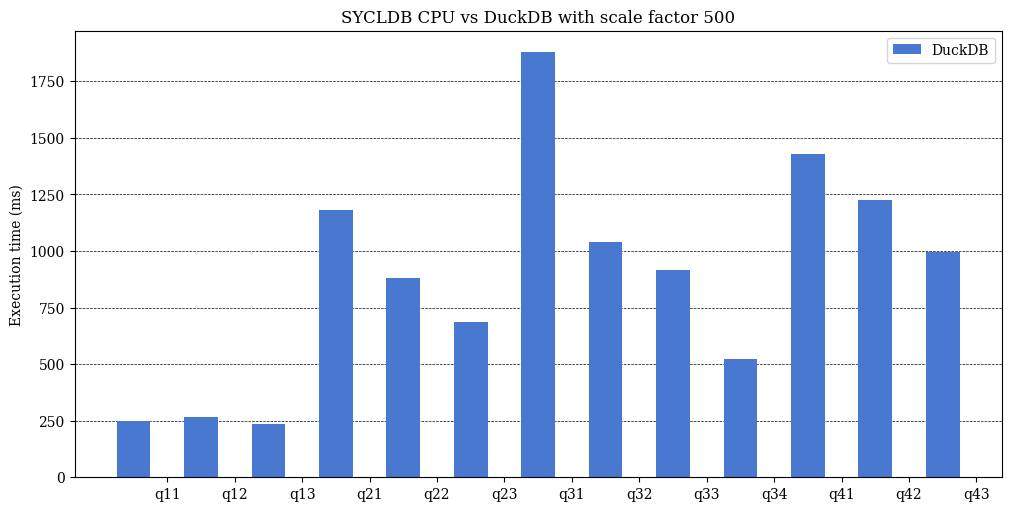

In [23]:
labels_mapping = {
    # 'cpu_ete_s500_avg': 'SYCLDB',
    'duckdb_s500_avg': 'DuckDB',
}

plot_data(comparison_cpu, labels_mapping, title='SYCLDB CPU vs DuckDB with scale factor 500')

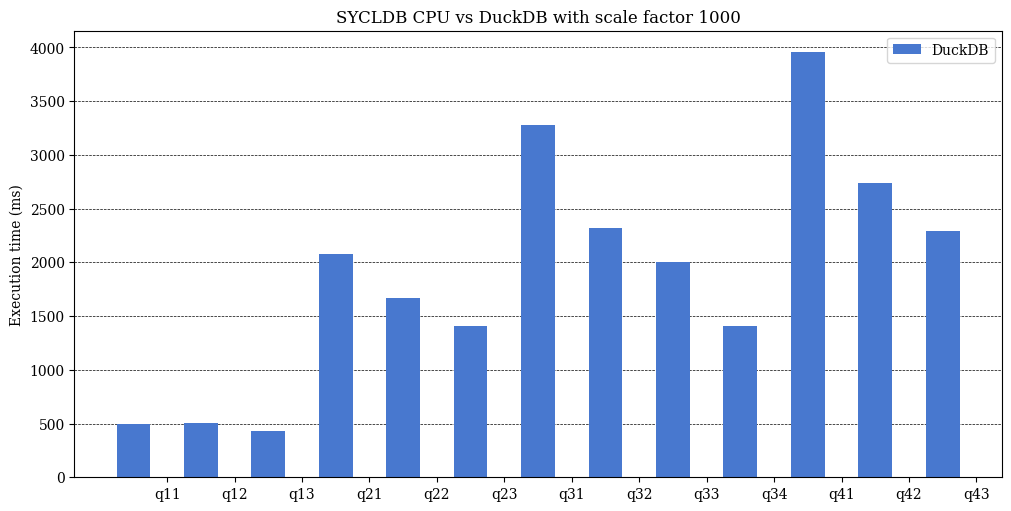

In [24]:
labels_mapping = {
    # 'cpu_ete_s1000_avg': 'SYCLDB',
    'duckdb_s1000_avg': 'DuckDB',
}

plot_data(comparison_cpu, labels_mapping, title='SYCLDB CPU vs DuckDB with scale factor 1000')

In [25]:
hybrid_results = pd.DataFrame()

for q in queries:
    cpu_s20_df = pd.read_csv(f'{q}-performance-cpu-s20.log', header=None, names=['execution_time_ms'])

    hybrid_s20_df = pd.read_csv(f'{q}-performance-hybrid-s20.log', header=None, names=['execution_time_ms'])

    hybrid_s160_cxl_df = pd.read_csv(f'{q}-performance-hybrid-cxl-s160.log', header=None, names=['execution_time_ms'])

    hybrid_mordred_s160_df = pd.read_csv(f'{q}-mordred-hybrid-s160.log', header=None, names=['execution_time_ms'])

    hybrid_results[f'{q}_hybrid_s20'] = hybrid_s20_df['execution_time_ms']

    hybrid_results[f'{q}_hybrid_s160_cxl'] = hybrid_s160_cxl_df['execution_time_ms']

    hybrid_results[f'{q}_hybrid_mordred_s160'] = hybrid_mordred_s160_df['execution_time_ms']
    
    hybrid_results[f'{q}_cpu_s20'] = cpu_s20_df['execution_time_ms']

    hybrid_results[f'{q}_cxl_cpu_s160'] = cpu_results[f'{q}_cpu_s160'] 

    hybrid_results[f'{q}_mordred_cpu_s160'] = cpu_results[f'{q}_mordred_s160']

hybrid_results[1:].describe()

,q11_hybrid_s20,q11_hybrid_s160_cxl,q11_hybrid_mordred_s160,q11_cpu_s20,q11_cxl_cpu_s160,q11_mordred_cpu_s160,q12_hybrid_s20,q12_hybrid_s160_cxl,q12_hybrid_mordred_s160,q12_cpu_s20,...,q42_hybrid_mordred_s160,q42_cpu_s20,q42_cxl_cpu_s160,q42_mordred_cpu_s160,q43_hybrid_s20,q43_hybrid_s160_cxl,q43_hybrid_mordred_s160,q43_cpu_s20,q43_cxl_cpu_s160,q43_mordred_cpu_s160
count,99.00000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,114.74897,1559.647172,115.885364,126.894737,1278.667980,85.240603,85.540647,409.321828,89.607872,98.723942,...,85.420882,140.306687,337.431374,143.718717,266.693657,437.682313,46.817691,115.856586,335.939818,129.283111
std,2.90982,127.547441,1.340009,1.917171,106.279273,7.850522,2.346093,38.204713,0.800097,1.372674,...,2.027445,2.318632,7.824035,14.056856,14.040518,84.225645,1.015781,1.296912,9.504632,9.507504
min,110.22900,1414.760000,114.076000,125.306000,1225.130000,82.292600,83.286300,328.327000,87.958700,97.415600,...,79.950700,137.869000,321.868000,137.093000,243.221000,233.839000,45.172800,114.247000,323.843000,114.305000
25%,112.91200,1487.700000,114.699500,125.788000,1237.755000,83.611450,84.424800,384.649000,89.029150,97.855650,...,84.297850,139.229000,332.314000,139.436500,254.606000,397.658500,46.203350,114.910000,329.469000,122.498500
50%,113.63300,1528.450000,115.350000,126.245000,1246.200000,84.057200,84.840600,411.448000,89.635300,98.286100,...,85.245000,139.727000,335.417000,140.356000,266.466000,434.090000,46.557700,115.454000,331.966000,127.920000
75%,115.81550,1563.125000,117.128500,127.309500,1264.135000,84.778500,85.550750,435.199000,90.357350,99.007450,...,86.328900,140.765500,340.914500,141.649500,276.549500,471.233500,47.190150,116.455500,340.137500,132.407500
max,124.32100,1952.200000,118.731000,138.078000,1732.650000,140.801000,97.384700,550.644000,90.881700,106.385000,...,93.012500,154.796000,361.726000,219.767000,299.616000,664.939000,50.735100,121.816000,374.133000,171.114000


In [26]:
comparison_hybrid = []

for q in queries[3:]:
    cpu_s20_avg = hybrid_results[f'{q}_cpu_s20'][1:].mean()
    cpu_s20_std = hybrid_results[f'{q}_cpu_s20'][1:].std()

    hybrid_s20_avg = hybrid_results[f'{q}_hybrid_s20'][1:].mean()
    hybrid_s20_std = hybrid_results[f'{q}_hybrid_s20'][1:].std()

    hybrid_s160_cxl_avg = hybrid_results[f'{q}_hybrid_s160_cxl'][1:].mean()
    hybrid_s160_cxl_std = hybrid_results[f'{q}_hybrid_s160_cxl'][1:].std()

    hybrid_mordred_s160_avg = hybrid_results[f'{q}_hybrid_mordred_s160'][1:].mean()
    hybrid_mordred_s160_std = hybrid_results[f'{q}_hybrid_mordred_s160'][1:].std()

    cpu_s160_avg = hybrid_results[f'{q}_cxl_cpu_s160'][1:].mean()
    cpu_s160_std = hybrid_results[f'{q}_cxl_cpu_s160'][1:].std()

    cpu_mordred_s160_avg = hybrid_results[f'{q}_mordred_cpu_s160'][1:].mean()
    cpu_mordred_s160_std = hybrid_results[f'{q}_mordred_cpu_s160'][1:].std()

    comparison_hybrid.append({
        'query': q,

        'cpu_s20_avg': cpu_s20_avg,
        # 'cpu_s20_std': cpu_s20_std,

        'hybrid_s20_avg': hybrid_s20_avg,
        # 'hybrid_s20_std': hybrid_s20_std,

        'hybrid_s160_cxl_avg': hybrid_s160_cxl_avg,
        'hybrid_s160_cxl_std': hybrid_s160_cxl_std,

        'hybrid_mordred_s160_avg': hybrid_mordred_s160_avg,
        'hybrid_mordred_s160_std': hybrid_mordred_s160_std,

        'cpu_s160_avg': cpu_s160_avg,
        'cpu_s160_std': cpu_s160_std,

        'cpu_mordred_s160_avg': cpu_mordred_s160_avg,
        'cpu_mordred_s160_std': cpu_mordred_s160_std,
    })

comparison_hybrid = pd.DataFrame(comparison_hybrid)
comparison_hybrid

,query,cpu_s20_avg,hybrid_s20_avg,hybrid_s160_cxl_avg,hybrid_s160_cxl_std,hybrid_mordred_s160_avg,hybrid_mordred_s160_std,cpu_s160_avg,cpu_s160_std,cpu_mordred_s160_avg,cpu_mordred_s160_std
0,q21,124.495636,183.879646,336.628495,43.097519,59.515743,1.637150,223.077222,10.558689,95.572295,19.544472
1,q22,105.386091,178.790131,312.773869,55.618052,52.641171,3.351372,228.889586,7.676116,77.812360,19.314985
2,q23,68.123621,126.428141,237.070586,37.709107,36.488626,0.847501,151.574939,6.966709,71.059921,15.081062
3,q31,138.344131,243.317919,617.828758,45.333504,190.018980,3.135690,320.211455,9.919325,166.971586,9.925261
4,q32,89.276255,223.211788,405.863121,78.008956,35.015598,1.615755,251.959273,9.917379,92.703508,4.218762
5,q33,83.305056,223.355040,398.873141,60.912542,27.780412,1.476484,225.442677,9.374800,63.985792,6.418259
6,q34,81.706575,221.943535,354.866596,45.772490,25.182996,0.872586,223.339343,8.119054,65.416320,13.904466
7,q41,169.937545,230.614788,523.577152,43.221002,397.646576,20.087771,376.890990,14.492394,197.346293,13.290349
8,q42,140.306687,271.421737,409.243889,68.778858,85.420882,2.027445,337.431374,7.824035,143.718717,14.056856
9,q43,115.856586,266.693657,437.682313,84.225645,46.817691,1.015781,335.939818,9.504632,129.283111,9.507504


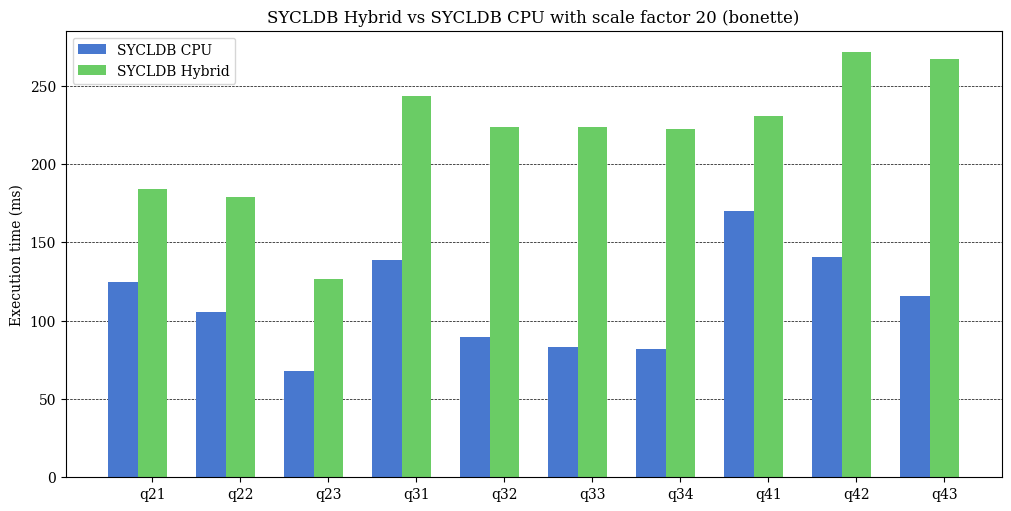

In [27]:
labels_mapping = {
    'cpu_s20_avg': 'SYCLDB CPU',
    'hybrid_s20_avg': 'SYCLDB Hybrid',
}

plot_data(comparison_hybrid, labels_mapping, title='SYCLDB Hybrid vs SYCLDB CPU with scale factor 20 (bonette)')

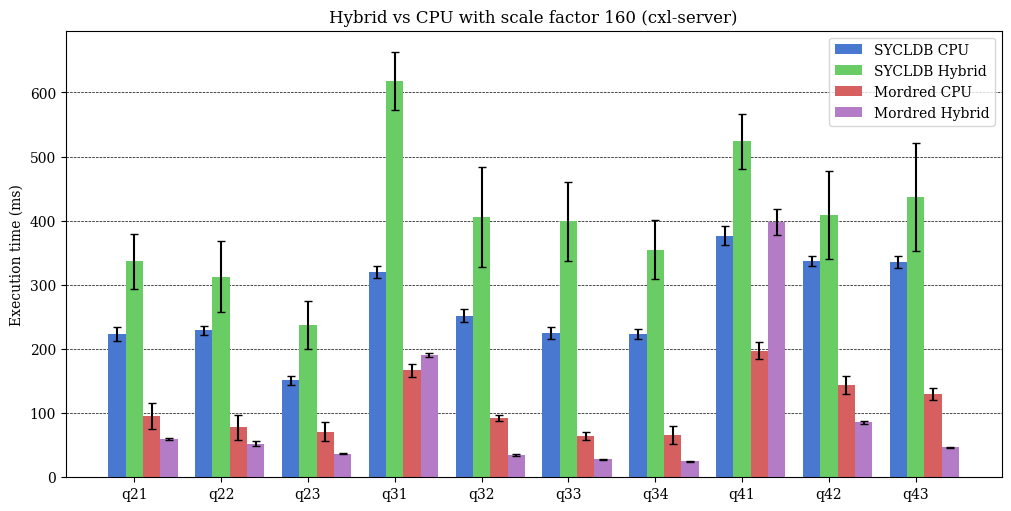

In [28]:
labels_mapping = {
    'cpu_s160_avg': 'SYCLDB CPU',
    'hybrid_s160_cxl_avg': 'SYCLDB Hybrid',
    'cpu_mordred_s160_avg': 'Mordred CPU',
    'hybrid_mordred_s160_avg': 'Mordred Hybrid',
}

plot_data(comparison_hybrid, labels_mapping, title='Hybrid vs CPU with scale factor 160 (cxl-server)')